# VGG Birds Transfer Learning

## Definition of Transfer Learning

Transfer learning (TL) is a research problem in machine learning (ML) that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. This area of research bears some relation to the long history of psychological literature on transfer of learning, although formal ties between the two fields are limited. From the practical standpoint, reusing or transferring information from previously learned tasks for the learning of new tasks has the potential to significantly improve the sample efficiency of a reinforcement learning agent.
<br><br>
Ressource from : [Wikipedia](https://en.wikipedia.org/wiki/Transfer_learning)

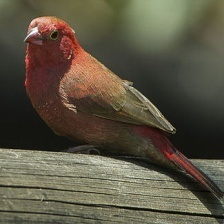

In [1]:
from IPython.display import Image
Image('./dataset/images to test/1.jpg')

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Split Data

In [3]:
top_path = './dataset/train'
birds = np.array(list(os.listdir(top_path)))

In [4]:
# pick only 20 type of birds to train on
nr_birds = 20

np.random.shuffle(birds)
# slicing the data
birds = birds[:nr_birds]

In [5]:
idx_to_name = {i:x for (i,x) in enumerate(birds)}
name_to_idx = {x:i for (i,x) in enumerate(birds)}
print(idx_to_name)

{0: 'NORTHERN FLICKER', 1: 'TROPICAL KINGBIRD', 2: 'LAZULI BUNTING', 3: 'PURPLE MARTIN', 4: 'CEDAR WAXWING', 5: 'BLACK-CAPPED CHICKADEE', 6: 'SHORT BILLED DOWITCHER', 7: 'CARMINE BEE-EATER', 8: 'CROW', 9: 'EVENING GROSBEAK', 10: 'GO AWAY BIRD', 11: 'CALIFORNIA QUAIL', 12: 'STRAWBERRY FINCH', 13: 'HAWFINCH', 14: 'KILLDEAR', 15: 'CHUCAO TAPACULO', 16: 'HEPATIC TANAGER', 17: 'PEACOCK', 18: 'PARADISE TANAGER', 19: 'EMERALD TANAGER'}


In [6]:
def get_data_labels(path, birds, dim):
    data = []
    labels = []

    for bird in birds:
        imgs = [cv2.resize(cv2.imread(img), dim, interpolation=cv2.INTER_AREA) for img in glob.glob(path + "/" + bird + "/*.jpg")]
        for img in imgs:
            data.append(img)
            labels.append(name_to_idx[bird])
    return np.array(data), np.array(labels)

In [7]:
data_train, labels_train = get_data_labels('./dataset/train', idx_to_name.values(), (224,224))
data_test, labels_test = get_data_labels('./dataset/test', idx_to_name.values(), (224,224))
data_valid, labels_valid = get_data_labels('./dataset/valid', idx_to_name.values(), (224,224))

In [8]:
def normalize(data):
    data = data / 255.0
    data = data.astype('float32')
    return data

def one_hot(labels):
    labels = np.eye(len(np.unique(labels)))[labels]
    return labels

In [9]:
data_train = normalize(data_train)
data_test = normalize(data_test)
data_valid = normalize(data_valid)

labels_train = one_hot(labels_train)
labels_test = one_hot(labels_test)
labels_valid = one_hot(labels_valid)

# Architecture

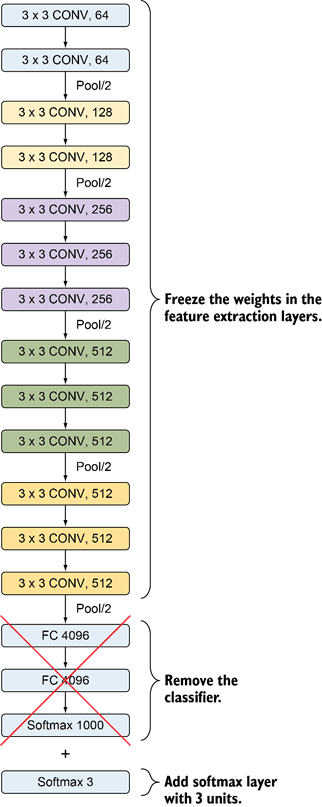

In [11]:
Image('../input/birds-transfer-learning/05-06_img_0027.png')

# Implementation

In [10]:
weights_path = "./dataset/pre-trained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(224, 224, 3))
base_model.summary()

2022-04-22 00:28:48.111555: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-22 00:28:48.112678: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (N

In [11]:
# Freeze the extraction layers
for layer in base_model.layers:
    layer.trainable = False
 
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
 
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('block5_pool')
# save the output of the last layer to be the input of the next layer
last_output = last_layer.output
 
# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)
 
# add our new softmax layer with 3 hidden units
x = Dense(nr_birds, activation='softmax', name='softmax')(x)

In [13]:
# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)
 
# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
checkpointer = ModelCheckpoint(filepath='birds.model.hdf5', save_best_only=True)
 
history = new_model.fit(data_train, labels_train, steps_per_epoch=len(data_train),
validation_data=(data_test, labels_test), validation_steps=3, epochs=10, verbose=1, callbacks=[checkpointer])

Epoch 1/10


2022-04-22 00:30:53.379856: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-22 00:30:54.058793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2925/2926 [============================>.] - ETA: 0s - loss: 1.0886 - accuracy: 0.7022

2022-04-22 00:32:07.595937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2926/2926 [==============================] - 77s 26ms/step - loss: 1.0882 - accuracy: 0.7023 - val_loss: 0.3524 - val_accuracy: 0.8900
Epoch 2/10
2926/2926 [==============================] - 98s 34ms/step - loss: 0.1690 - accuracy: 0.9658 - val_loss: 0.2458 - val_accuracy: 0.9400
Epoch 3/10
2926/2926 [==============================] - 137s 47ms/step - loss: 0.0414 - accuracy: 0.9969 - val_loss: 0.1845 - val_accuracy: 0.9500
Epoch 4/10
2926/2926 [==============================] - 143s 49ms/step - loss: 0.0157 - accuracy: 0.9997 - val_loss: 0.2475 - val_accuracy: 0.9100
Epoch 5/10
2926/2926 [==============================] - 152s 52ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1038 - val_accuracy: 0.9900
Epoch 6/10
2926/2926 [==============================] - 159s 54ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0922 - val_accuracy: 0.9800
Epoch 7/10
2926/2926 [==============================] - 152s 52ms/step - loss: 8.0517e-04 - accuracy: 1.0000 - val_loss: 0.1049 - v

In [17]:
# Analyze Training Data

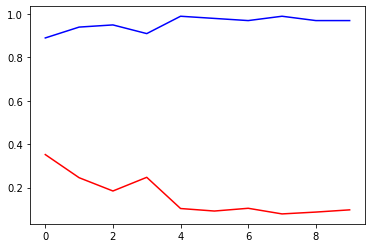

In [18]:
plt.plot(history.history['val_accuracy'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.show()

In [19]:
def get_accuracy(model, data_valid, labels_valid):
    predictions = model(data_valid)
    wrong = 0
    for i, pred in enumerate(predictions):
        if( np.argmax(pred) !=  np.argmax(labels_valid[i])):
            wrong += 1
    return (len(data_valid) - wrong) / len(data_valid)

In [20]:
# we use the validation data to verify the accuracy
accuracy = get_accuracy(new_model, data_valid, labels_valid)
print("Accuracy:", accuracy)

Accuracy: 0.96


In [21]:
new_model.save('birds-trained-model')

2022-04-22 00:54:42.935675: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: birds-trained-model/assets


# Resources

Architectures images from [Deep Learning for Vision Systems Book](https://www.manning.com/books/deep-learning-for-vision-systems)